Modeling and Evaluation Notebook:

Pipeline Setup
Train/Test Split or 5-fold cross-validation
Models:
- Logistic Regression baseline 
- Additional models: Random Forest, Gradient Boosting (XGBoost), Neural Network, SVM with RBF Kernel
- Super additional models: DecisionTree ("low end"), Genetic Algorithm ("high end")
Evaluation (accuracy, AUC, Precision, Recall, F1)
Debiasing method + fairness metrics
Reflection and interpretation

Pipeline Setup:

In [ ]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, roc_curve

# 2. Load Data
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
X = df.drop("is_recid", axis=1)
y = df["is_recid"]

# 3. Define scoring metrics
scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
    'accuracy': make_scorer(accuracy_score)
}

# 4. Create pipelines for each model
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("clf", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42))
    ]),
    "SVM (RBF Kernel)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel='rbf', probability=True, random_state=42))
    ])
}



Pipeline Setup: 5-fold crossvalidation
Use StratifiedKfold to ensure that each fold in the cross-validation process has approximately the same proportion of target classes (recidivist vs. non-recidivist) as the full dataset. 
The is_recid target is imbalanced (around 30–35% positive class).

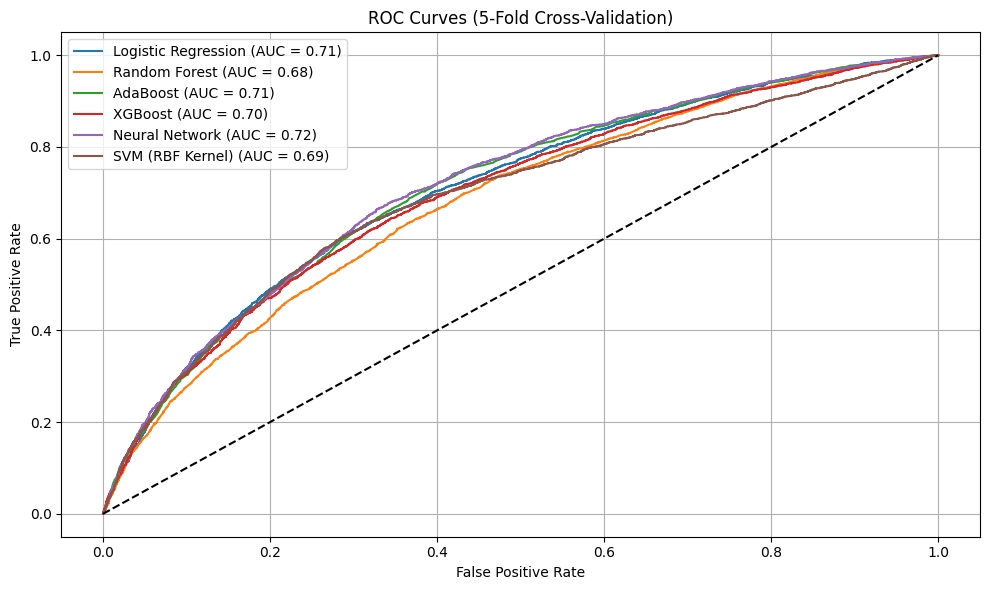

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression,0.691,0.650,0.276,0.388,0.708
1,Random Forest,0.666,0.532,0.469,0.499,0.681
2,AdaBoost,0.691,0.601,0.374,0.461,0.710
3,XGBoost,0.688,0.583,0.408,0.480,0.698
4,Neural Network,0.696,0.613,0.381,0.470,0.715
5,SVM (RBF Kernel),0.693,0.646,0.290,0.401,0.690


In [97]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# Load the dataset
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
X = df.drop("is_recid", axis=1)
y = df["is_recid"]

# Split into trainval (85%) and test (15%) set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# Initialize 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Use StratifiedKfold for imbalanced classes

# Define models with pipelines
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    "AdaBoost": Pipeline([
        ("clf", AdaBoostClassifier(n_estimators=100, random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
    ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42))
    ]),
    "SVM (RBF Kernel)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel='rbf', probability=True, random_state=42))
    ])
}

# Evaluate each model
results = []
plt.figure(figsize=(10, 6))

for name, model in models.items():
    y_proba = cross_val_predict(model, X_trainval, y_trainval, cv=cv, method="predict_proba")[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    acc = accuracy_score(y_trainval, y_pred)
    precision = precision_score(y_trainval, y_pred)
    recall = recall_score(y_trainval, y_pred)
    f1 = f1_score(y_trainval, y_pred)
    auc = roc_auc_score(y_trainval, y_proba)

    fpr, tpr, _ = roc_curve(y_trainval, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "AUC": round(auc, 3)
    })

# Plot formatting
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (5-Fold Cross-Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../data/model_comparison_roc_curves_with_adaboost.png")
plt.show()

# Show results
results_df = pd.DataFrame(results)

# Define fixed order of models
model_order = [
    "Logistic Regression",
    "Random Forest",
    "AdaBoost",
    "XGBoost",
    "Neural Network",
    "SVM (RBF Kernel)"
]

# Create DataFrame and sort by model order
results_df = pd.DataFrame(results)
results_df["Model"] = pd.Categorical(results_df["Model"], categories=model_order, ordered=True)
results_df = results_df.sort_values("Model").reset_index(drop=True)
results_df.to_csv("../reports/model_performance_comparison_5-foldcv.csv", index=False)
results_df



Pipeline Setup: alternatively 80/20 Train/Test Split

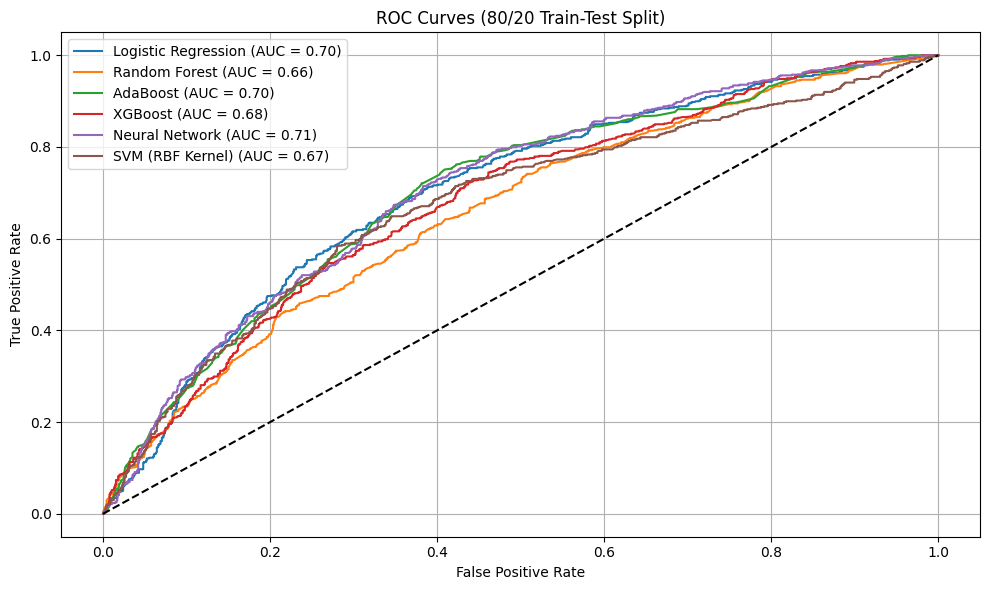

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression,0.678,0.606,0.260,0.364,0.703
1,Random Forest,0.658,0.519,0.445,0.479,0.658
2,AdaBoost,0.680,0.575,0.367,0.448,0.702
3,XGBoost,0.671,0.550,0.400,0.463,0.681
4,Neural Network,0.685,0.597,0.342,0.435,0.707
5,SVM (RBF Kernel),0.678,0.605,0.262,0.365,0.675


In [99]:
# Re-import required packages after kernel reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# Load the dataset
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
X = df.drop("is_recid", axis=1)
y = df["is_recid"]

# 85% train/val, 15% test split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

# 80% train / 20% val within train/val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42)

# Define models with pipelines
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    "AdaBoost": Pipeline([
        ("clf", AdaBoostClassifier(n_estimators=100, random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
    ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42))
    ]),
    "SVM (RBF Kernel)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel='rbf', probability=True, random_state=42))
    ])
}

# Evaluate each model
results = []
plt.figure(figsize=(10, 6))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_val)[:, 1]
    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)

    fpr, tpr, _ = roc_curve(y_val, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "AUC": round(auc, 3)
    })

# Plot formatting
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (80/20 Train-Test Split)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../data/model_comparison_roc_curves_80-20split.png")
plt.show()

# Show results
results_df = pd.DataFrame(results)

# Define fixed order of models
model_order = [
    "Logistic Regression",
    "Random Forest",
    "AdaBoost",
    "XGBoost",
    "Neural Network",
    "SVM (RBF Kernel)"
]

# Create DataFrame and sort by model order
results_df = pd.DataFrame(results)
results_df["Model"] = pd.Categorical(results_df["Model"], categories=model_order, ordered=True)
results_df = results_df.sort_values("Model").reset_index(drop=True)
results_df.to_csv("../reports/model_performance_comparison_80-20ttsplit.csv", index=False)
results_df



Hyperparameter Tuning: 
Include GridSearch for each model. 

Tuning Logistic Regression...
Tuning Random Forest...
Tuning AdaBoost...
Tuning XGBoost...
Tuning Neural Network...
Tuning SVM (RBF Kernel)...


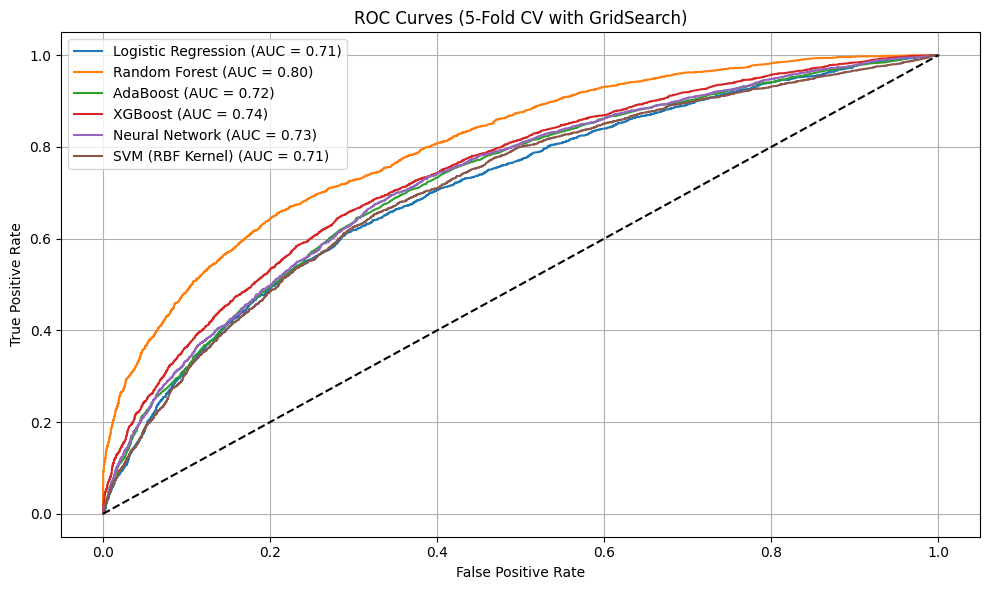

,Model,Accuracy,Precision,Recall,F1 Score,AUC,Best Params
0,Logistic Regression,0.690,0.650,0.267,0.379,0.709,{'clf__C': 10}
1,Random Forest,0.751,0.744,0.452,0.562,0.802,"{'clf__max_depth': 10, 'clf__min_samples_split..."
2,AdaBoost,0.696,0.614,0.379,0.469,0.723,"{'clf__learning_rate': 0.5, 'clf__n_estimators..."
3,XGBoost,0.712,0.636,0.435,0.517,0.742,"{'clf__learning_rate': 0.1, 'clf__max_depth': ..."
4,Neural Network,0.700,0.621,0.391,0.479,0.727,"{'clf__alpha': 0.001, 'clf__hidden_layer_sizes..."
5,SVM (RBF Kernel),0.682,0.651,0.217,0.326,0.711,"{'clf__C': 1, 'clf__gamma': 0.01}"


In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# Load data
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
X = df.drop("is_recid", axis=1)
y = df["is_recid"]

# Split into trainval (85%) and test (15%) set
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# Initialize 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Use StratifiedKfold for imbalanced classes

# Define models
base_models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(random_state=42))
    ]),
    "AdaBoost": Pipeline([
        ("clf", AdaBoostClassifier(random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
    ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(max_iter=300, random_state=42))
    ]),
    "SVM (RBF Kernel)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel='rbf', probability=True, random_state=42))
    ])
}

# Define hyperparameter grids
param_grids = {
    "Logistic Regression": {
        "clf__C": [0.01, 0.1, 1, 10]
    },
    "Random Forest": {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5]
    },
    "AdaBoost": {
        "clf__n_estimators": [50, 100, 200],
        "clf__learning_rate": [0.5, 1.0]
    },
    "XGBoost": {
        "clf__n_estimators": [50, 100],
        "clf__max_depth": [3, 5],
        "clf__learning_rate": [0.1, 0.3]
    },
    "Neural Network": {
        "clf__hidden_layer_sizes": [(32,), (64,), (64, 32)],
        "clf__alpha": [0.0001, 0.001]
    },
    "SVM (RBF Kernel)": {
        "clf__C": [0.1, 1, 10],
        "clf__gamma": ['scale', 0.01, 0.1]
    }
}

# Placeholder for storing results
results = []
plt.figure(figsize=(10, 6))

# Perform GridSearchCV for each model
for name in base_models:
    print(f"Tuning {name}...")
    grid = GridSearchCV(base_models[name], param_grids[name], cv=cv, scoring="roc_auc", n_jobs=-1)
    grid.fit(X, y)
    best_model = grid.best_estimator_

    # Predict and evaluate
    y_proba = best_model.predict_proba(X_trainval)[:, 1]
    y_pred = best_model.predict(X_trainval)

    acc = accuracy_score(y_trainval, y_pred)
    precision = precision_score(y_trainval, y_pred)
    recall = recall_score(y_trainval, y_pred)
    f1 = f1_score(y_trainval, y_pred)
    auc = roc_auc_score(y_trainval, y_proba)

    fpr, tpr, _ = roc_curve(y_trainval, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

    
    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "AUC": round(auc, 3),
        "Best Params": grid.best_params_
    })

# Final ROC Curve Plot
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (5-Fold CV with GridSearch)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../data/model_comparison_roc_cv_tuned.png")
plt.show()

# Show results
results_df = pd.DataFrame(results)

# Define fixed order of models
model_order = [
    "Logistic Regression",
    "Random Forest",
    "AdaBoost",
    "XGBoost",
    "Neural Network",
    "SVM (RBF Kernel)"
]

# Create DataFrame and sort by model order
results_df = pd.DataFrame(results)
results_df["Model"] = pd.Categorical(results_df["Model"], categories=model_order, ordered=True)
results_df = results_df.sort_values("Model").reset_index(drop=True)
results_df.to_csv("../reports/model_performance_comparison_cv_tuned_results.csv", index=False)
results_df




Tuning Logistic Regression...
Tuning Random Forest...
Tuning AdaBoost...
Tuning XGBoost...
Tuning Neural Network...
Tuning SVM (RBF Kernel)...


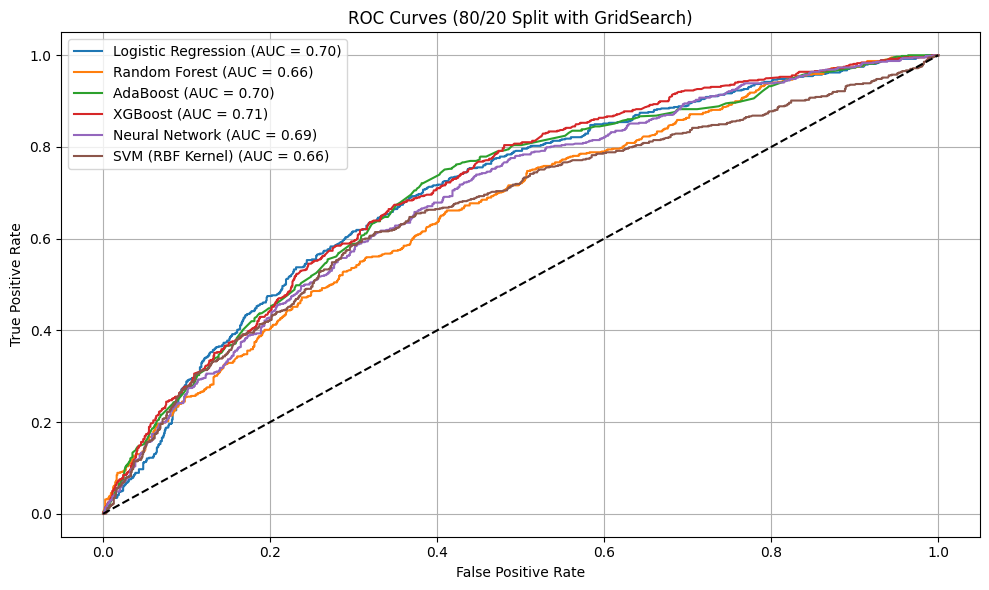

,Model,Accuracy,Precision,Recall,F1 Score,AUC,Best Params
0,Logistic Regression,0.678,0.606,0.260,0.364,0.703,{'clf__C': 1}
1,Random Forest,0.660,0.523,0.444,0.480,0.665,"{'clf__max_depth': 20, 'clf__n_estimators': 200}"
2,AdaBoost,0.680,0.575,0.367,0.448,0.702,"{'clf__learning_rate': 1.0, 'clf__n_estimators..."
3,XGBoost,0.677,0.566,0.376,0.452,0.710,"{'clf__learning_rate': 0.3, 'clf__max_depth': ..."
4,Neural Network,0.671,0.550,0.389,0.455,0.688,"{'clf__alpha': 0.001, 'clf__hidden_layer_sizes..."
5,SVM (RBF Kernel),0.680,0.609,0.266,0.371,0.661,"{'clf__C': 10, 'clf__gamma': 'scale'}"


In [103]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

# Load dataset
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
X = df.drop("is_recid", axis=1)
y = df["is_recid"]

# 85% train/val, 15% test split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

# 80% train / 20% val within train/val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42)

# Define models and parameter grids
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(random_state=42))
    ]),
    "AdaBoost": Pipeline([
        ("clf", AdaBoostClassifier(random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
    ]),
    "Neural Network": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(max_iter=300, random_state=42))
    ]),
    "SVM (RBF Kernel)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel='rbf', probability=True, random_state=42))
    ])
}

param_grids = {
    "Logistic Regression": {"clf__C": [0.01, 0.1, 1, 10]},
    "Random Forest": {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [None, 10, 20]
    },
    "AdaBoost": {
        "clf__n_estimators": [50, 100],
        "clf__learning_rate": [0.5, 1.0]
    },
    "XGBoost": {
        "clf__n_estimators": [50, 100],
        "clf__max_depth": [3, 5],
        "clf__learning_rate": [0.1, 0.3]
    },
    "Neural Network": {
        "clf__hidden_layer_sizes": [(32,), (64,), (64, 32)],
        "clf__alpha": [0.0001, 0.001]
    },
    "SVM (RBF Kernel)": {
        "clf__C": [0.1, 1, 10],
        "clf__gamma": ['scale', 0.01, 0.1]
    }
}

# Model training and evaluation
results = []
plt.figure(figsize=(10, 6))

for name, pipeline in models.items():
    print(f"Tuning {name}...")
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        cv=5,
        scoring="f1",
        n_jobs=-1
    )
    
    # Fit on training data
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    
    # Predict on validation data
    y_proba = best_model.predict_proba(X_val)[:, 1]
    y_pred = best_model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)

    fpr, tpr, _ = roc_curve(y_val, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

    results.append({
        "Model": name,
        "Accuracy": round(acc, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "AUC": round(auc, 3),
        "Best Params": grid.best_params_
    })

# Final ROC Curve Plot
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (80/20 Split with GridSearch)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../data/model_comparison_roc_curves_80-20split_tuned.png")
plt.show()

# Show results
results_df = pd.DataFrame(results)

# Define fixed order of models
model_order = [
    "Logistic Regression",
    "Random Forest",
    "AdaBoost",
    "XGBoost",
    "Neural Network",
    "SVM (RBF Kernel)"
]

# Create DataFrame and sort by model order
results_df = pd.DataFrame(results)
results_df["Model"] = pd.Categorical(results_df["Model"], categories=model_order, ordered=True)
results_df = results_df.sort_values("Model").reset_index(drop=True)
results_df.to_csv("../reports/model_performance_comparison_80-20ttsplit_tuned_results.csv", index=False)
results_df

Compare tuned models for selection of the two best models: 

In [104]:
import pandas as pd

# Load both performance result CSVs
df_cv = pd.read_csv("../reports/model_performance_comparison_cv_tuned_results.csv")
df_split = pd.read_csv("../reports/model_performance_comparison_80-20ttsplit_tuned_results.csv")

# Add source column for clarity
df_cv["Setup"] = "5-Fold CV"
df_split["Setup"] = "80/20 Split"

# Combine for comparison
combined_df = pd.concat([df_cv, df_split], ignore_index=True)

# Compare average F1, Recall, Precision, Accuracy across setups
summary = combined_df.groupby("Setup")[["F1 Score", "Recall", "Precision", "Accuracy"]].mean().round(3)

summary


,F1 Score,Recall,Precision,Accuracy
Setup,,,,
5-Fold CV,0.455,0.357,0.653,0.705
80/20 Split,0.428,0.350,0.572,0.674


As performances from the tuned 5-fold cross-validation are best, this setup will be selected for selection of the best models. 
Selection logic alternative A priorities: Precision → F1 → Recall → Accuracy

In [111]:
# Model selection criteria: (Precision > F1 > Recall > Accuracy)

import pandas as pd

# Load the model performance results
results_df = pd.read_csv("../reports/model_performance_comparison_cv_tuned_results.csv")

# Logistic Regression as baseline
baseline_model = results_df[results_df["Model"] == "Logistic Regression"]

# Exclude Logistic Regression from selection ranking
ranked_df_b = results_df[results_df["Model"] != "Logistic Regression"].copy()

# Rank each metric
ranked_df_b["Precision_rank"] = ranked_df_b["Precision"].rank(ascending=False, method="min")
ranked_df_b["F1_rank"] = ranked_df_b["F1 Score"].rank(ascending=False, method="min")
ranked_df_b["Recall_rank"] = ranked_df_b["Recall"].rank(ascending=False, method="min")
ranked_df_b["Accuracy_rank"] = ranked_df_b["Accuracy"].rank(ascending=False, method="min")

# Weighted score: Recall most important
ranked_df_b["Overall_rank_B"] = (
    ranked_df_b["Precision_rank"] * 1 +
    ranked_df_b["F1_rank"] * 2 +
    ranked_df_b["Recall_rank"] * 3 +
    ranked_df_b["Accuracy_rank"] * 4
)

# Sort and select top 2 models
best_models_B = ranked_df_b.sort_values("Overall_rank_B").head(2)

# Combine with baseline
selected_models_B = pd.concat([baseline_model, best_models_B], ignore_index=True)
print("Alternative A - Top Models (Precision > F1 > Recall > Accuracy):")
print(selected_models_B[["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"]])


Alternative A - Top Models (Precision > F1 > Recall > Accuracy):
                 Model  Accuracy  Precision  Recall  F1 Score    AUC
0  Logistic Regression     0.690      0.650   0.267     0.379  0.709
1        Random Forest     0.751      0.744   0.452     0.562  0.802
2              XGBoost     0.712      0.636   0.435     0.517  0.742


Selection logic alternative B priorities: F1 → Precision → Recall → Accuracy

In [109]:

# Model selection criteria: F1 > Precision > Recall > Accuracy

import pandas as pd

# Load the model performance results
results_df = pd.read_csv("../reports/model_performance_comparison_cv_tuned_results.csv")

# Logistic Regression as baseline
baseline_model = results_df[results_df["Model"] == "Logistic Regression"]

# Exclude Logistic Regression from selection ranking
ranked_df_a = results_df[results_df["Model"] != "Logistic Regression"].copy()

# Rank each metric (higher = better)
ranked_df_a["F1_rank"] = ranked_df_a["F1 Score"].rank(ascending=False, method="min")
ranked_df_a["Precision_rank"] = ranked_df_a["Precision"].rank(ascending=False, method="min")
ranked_df_a["Recall_rank"] = ranked_df_a["Recall"].rank(ascending=False, method="min")
ranked_df_a["Accuracy_rank"] = ranked_df_a["Accuracy"].rank(ascending=False, method="min")

# Weighted score: F1 (highest priority), then Recall, then Precision, then Accuracy
ranked_df_a["Overall_rank_A"] = (
    ranked_df_a["F1_rank"] * 1 +
    ranked_df_a["Precision_rank"] * 2 +
    ranked_df_a["Recall_rank"] * 3 +
    ranked_df_a["Accuracy_rank"] * 4
)

# Sort and select top 2 models
best_models_A = ranked_df_a.sort_values("Overall_rank_A").head(2)

# Combine with baseline
selected_models_A = pd.concat([baseline_model, best_models_A], ignore_index=True)
print("Alternative B - Top Models (F1 > Precision > Recall > Accuracy):")
print(selected_models_A[["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"]])

Alternative B - Top Models (F1 > Precision > Recall > Accuracy):
                 Model  Accuracy  Precision  Recall  F1 Score    AUC
0  Logistic Regression     0.690      0.650   0.267     0.379  0.709
1        Random Forest     0.751      0.744   0.452     0.562  0.802
2              XGBoost     0.712      0.636   0.435     0.517  0.742


Finetune the two selected models Random Forest and XGBoost, one after each other. 


=== Training and tuning: Random Forest ===
Optimal threshold selected: 0.70 (Precision=0.622, F1=0.279)


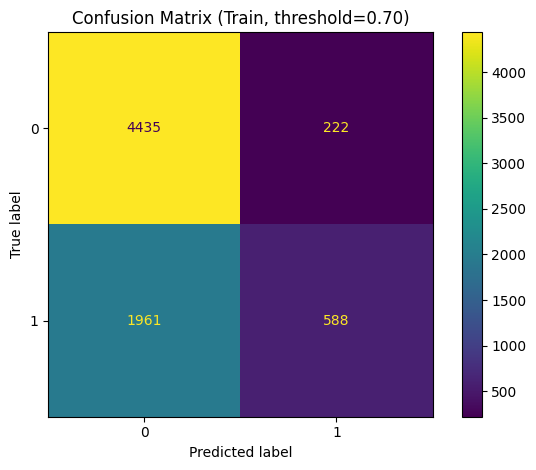

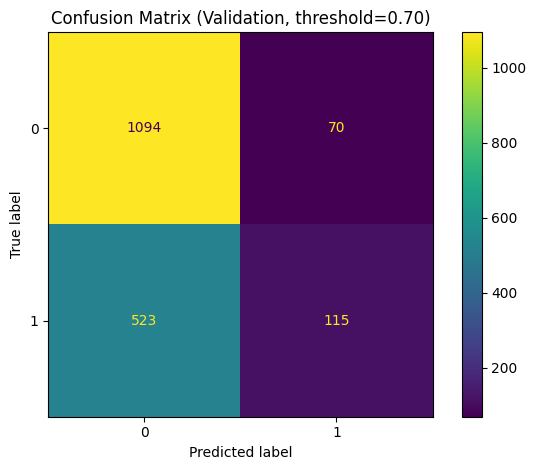

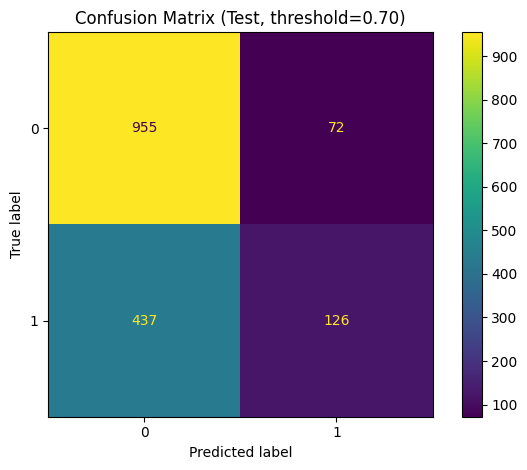

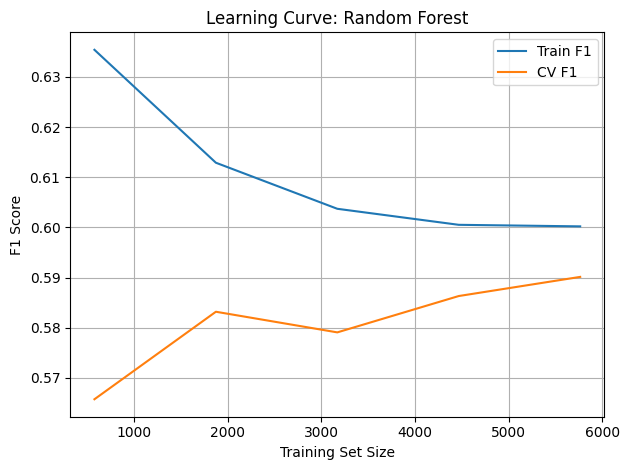

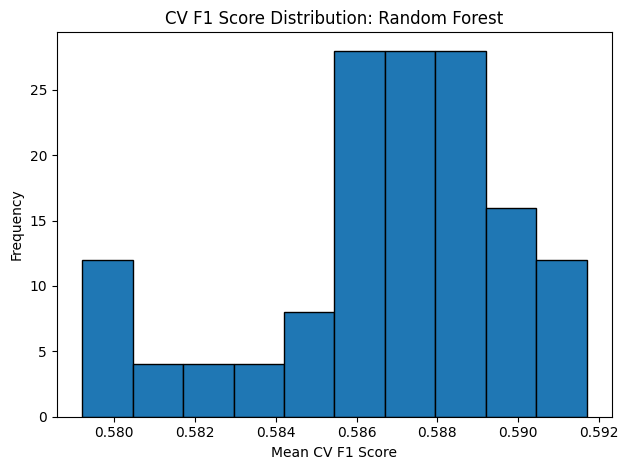

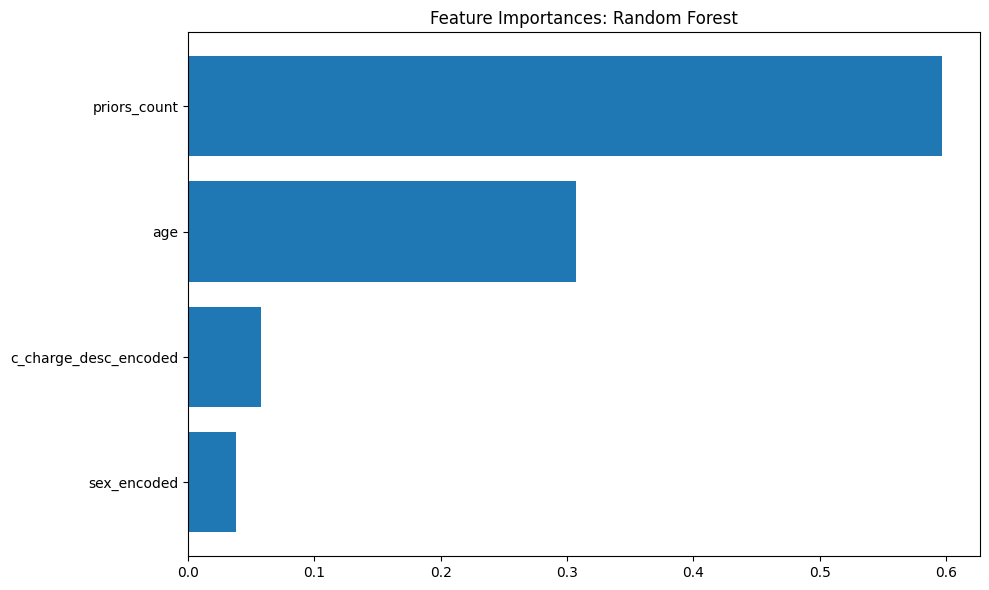

,Set,Threshold,Accuracy,Precision,Recall,F1 Score,AUC
0,Train,0.7,0.697,0.726,0.231,0.350,0.738
1,Validation,0.7,0.671,0.622,0.180,0.279,0.702
2,Test,0.7,0.680,0.636,0.224,0.331,0.718


In [142]:
# # RANDOM FOREST FINETUNING

# # Import required packages due to code state reset
# import pandas as pd
# import json
# import os
# import joblib
# import matplotlib.pyplot as plt
# from sklearn.model_selection import StratifiedKFold, GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from sklearn.metrics import (
#     make_scorer, f1_score, accuracy_score, precision_score, recall_score,
#     roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
# )

# # Load the dataset again
# df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
# X = df.drop("is_recid", axis=1)
# y = df["is_recid"]

# # Split into trainval (85%) and test (15%) set
# X_trainval, X_test, y_trainval, y_test = train_test_split(
#     X, y, test_size=0.15, stratify=y, random_state=42
# )

# # Cross-validation setup
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Parameter grids for tuning
# param_grids = {
#     "Random Forest": {
#         "clf__n_estimators": [100, 200],
#         "clf__max_depth": [None, 10, 20],
#         "clf__min_samples_split": [2, 5]
#     }
# }

# # Base model pipelines
# pipelines = {
#     "Random Forest": Pipeline([
#         ("clf", RandomForestClassifier(random_state=42))
#     ])
# }

# # Use F1-score for tuning
# scorer = make_scorer(f1_score)

# os.makedirs("../reports", exist_ok=True)

# # Run GridSearchCV for models
# best_estimators = {}
# for name, pipeline in pipelines.items():
#     grid_search = GridSearchCV(
#         estimator=pipeline,
#         param_grid=param_grids[name],
#         scoring=scorer,
#         cv=cv,
#         n_jobs=-1,
#         verbose=0
#     )
#     grid_search.fit(X_trainval, y_trainval)
#     best_estimators[name] = grid_search.best_estimator_

# # Evaluate the best estimators and extract metrics
# evaluation_results = []

# for name, model in best_estimators.items():
#     y_proba = model.predict_proba(X_trainval)[:, 1]
#     y_pred = model.predict(X_trainval)

#     accuracy = accuracy_score(y_trainval, y_pred)
#     precision = precision_score(y_trainval, y_pred)
#     recall = recall_score(y_trainval, y_pred)
#     f1 = f1_score(y_trainval, y_pred)
#     auc = roc_auc_score(y_trainval, y_proba)
#     cm = confusion_matrix(y_trainval, y_pred)

#     # Display Confusion Matrix
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
#     disp.plot()
#     plt.title(f"Confusion Matrix: {name}")
#     plt.grid(False)
#     plt.tight_layout()
#     plt.savefig(f"../reports/confusion_matrix_finetuned_{name.lower().replace(' ', '_')}.png")
#     plt.show()

#     evaluation_results.append({
#         "Model": name,
#         "Best Parameters": model.get_params(),
#         "Accuracy": round(accuracy, 3),
#         "Precision": round(precision, 3),
#         "Recall": round(recall, 3),
#         "F1 Score": round(f1, 3),
#         "AUC": round(auc, 3),
#         "Confusion Matrix": cm
#     })


#     # Save only best tuned hyperparameters
#     with open(f"../reports/best_params_{name.lower().replace(' ', '_')}.json", "w") as f:
#         json.dump(grid_search.best_params_, f, indent=2)

# # Create models directory if it doesn't exist
# os.makedirs("../models", exist_ok=True)

# # Save the tuned Random Forest model
# joblib.dump(best_estimators["Random Forest"], "../models/random_forest_finetuned.pkl")

# # Save metrics
# eval_df = pd.DataFrame(evaluation_results)
# eval_df.to_csv("../reports/tuned_randomforest_model_metrics_summary.csv", index=False)

# eval_df

# RANDOM FOREST FINETUNING — FULL WORKFLOW

# === YOUR COMPLETE ADAPTED PIPELINE WITH SMOTE + THRESHOLD TUNING ===

import os
import json
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, learning_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    make_scorer, f1_score, accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
)

# === Load Data ===
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
low_info_features = ["c_charge_degree_encoded", "juv_misd_count", "juv_fel_count"]
X = df.drop(["is_recid"] + low_info_features, axis=1)
y = df["is_recid"]

# === Train/Val/Test Split ===
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42)

# === CV and Pipeline Setup ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grids = {
    "Random Forest": {
        "clf__n_estimators": [50, 100],
        "clf__max_depth": [3, 5, 7],
        "clf__min_samples_split": [2, 5],
        "clf__min_samples_leaf": [5, 10, 20],
        "clf__max_features": ['sqrt', 0.5],
        "clf__bootstrap": [True, False]
    }
}

pipelines = {
    "Random Forest": Pipeline([
        ("clf", RandomForestClassifier(random_state=42, class_weight="balanced"))
    ])
}

os.makedirs("../models", exist_ok=True)
os.makedirs("../reports", exist_ok=True)

thresholds = np.linspace(0.60, 0.70, 11)  # 0.60, 0.61, ..., 0.70
evaluation_results = []

for name, pipeline in pipelines.items():
    print(f"\n=== Training and tuning: {name} ===")

    # === Apply SMOTE on training data ===
    # smote = SMOTE(random_state=42)
    # X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # === Grid Search on oversampled data ===
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        scoring=make_scorer(f1_score),
        cv=cv,
        n_jobs=-1,
        verbose=0,
        return_train_score=True
    )
    # grid_search.fit(X_train_smote, y_train_smote)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # === Save Model and Params ===
    joblib.dump(best_model, f"../models/{name.lower().replace(' ', '_')}_finetuned.pkl")
    with open(f"../reports/best_params_{name.lower().replace(' ', '_')}.json", "w") as f:
        json.dump(grid_search.best_params_, f, indent=2)

    pd.DataFrame(grid_search.cv_results_).to_csv(
        f"../reports/gridsearch_results_{name.lower().replace(' ', '_')}.csv", index=False
    )

    # === Threshold tuning on validation set ===
    y_val_proba = best_model.predict_proba(X_val)[:, 1]
    threshold_metrics = []
    for t in thresholds:
        y_pred = (y_val_proba >= t).astype(int)
        precision = precision_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        threshold_metrics.append({"Threshold": t, "Precision": precision, "F1": f1})
    threshold_df = pd.DataFrame(threshold_metrics)
    best_row = threshold_df.loc[threshold_df["Precision"].idxmax()]
    best_threshold = best_row["Threshold"]
    print(f"Optimal threshold selected: {best_threshold:.2f} (Precision={best_row['Precision']:.3f}, F1={best_row['F1']:.3f})")

    # === Evaluation function with threshold ===
    def evaluate_with_threshold(X_data, y_true, set_name):
        y_proba = best_model.predict_proba(X_data)[:, 1]
        y_pred = (y_proba >= best_threshold).astype(int)

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_proba)
        cm = confusion_matrix(y_true, y_pred)

        # Confusion Matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
        disp.plot()
        plt.title(f"Confusion Matrix ({set_name}, threshold={best_threshold:.2f})")
        plt.grid(False)
        plt.tight_layout()
        plt.savefig(f"../reports/conf_matrix_threshold_{set_name.lower()}.png")
        plt.show()

        # Classification Report
        report = classification_report(y_true, y_pred, target_names=["No Recidivism", "Recidivism"])
        with open(f"../reports/classification_report_threshold_{set_name.lower()}.txt", "w") as f:
            f.write(report)

        return {
            "Set": set_name,
            "Threshold": best_threshold,
            "Accuracy": round(acc, 3),
            "Precision": round(prec, 3),
            "Recall": round(rec, 3),
            "F1 Score": round(f1, 3),
            "AUC": round(auc, 3)
        }

    evaluation_results.append(evaluate_with_threshold(X_train, y_train, "Train"))
    evaluation_results.append(evaluate_with_threshold(X_val, y_val, "Validation"))
    evaluation_results.append(evaluate_with_threshold(X_test, y_test, "Test"))

    # === Learning Curve ===
    train_sizes, train_scores, val_scores = learning_curve(
        best_model, X_train, y_train, cv=cv,
        scoring="f1", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5),
        shuffle=True, random_state=42
    )
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)
    plt.figure()
    plt.plot(train_sizes, train_mean, label="Train F1")
    plt.plot(train_sizes, val_mean, label="CV F1")
    plt.xlabel("Training Set Size")
    plt.ylabel("F1 Score")
    plt.title(f"Learning Curve: {name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"../reports/learning_curve_{name.lower().replace(' ', '_')}.png")
    plt.show()

    # === CV Score Histogram ===
    cv_scores = grid_search.cv_results_['mean_test_score']
    plt.figure()
    plt.hist(cv_scores, bins=10, edgecolor="k")
    plt.title(f"CV F1 Score Distribution: {name}")
    plt.xlabel("Mean CV F1 Score")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(f"../reports/cv_score_distribution_{name.lower().replace(' ', '_')}.png")
    plt.show()

    # === Feature Importances ===
    if hasattr(best_model.named_steps["clf"], "feature_importances_"):
        importances = best_model.named_steps["clf"].feature_importances_
        feature_names = X.columns
        importance_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": importances
        }).sort_values(by="Importance", ascending=False)

        plt.figure(figsize=(10, 6))
        plt.barh(importance_df["Feature"], importance_df["Importance"])
        plt.title(f"Feature Importances: {name}")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig(f"../reports/feature_importance_{name.lower().replace(' ', '_')}.png")
        plt.show()

        importance_df.to_csv(f"../reports/feature_importances_{name.lower().replace(' ', '_')}.csv", index=False)

# === Save final threshold-evaluated metrics ===
eval_df = pd.DataFrame(evaluation_results)
eval_df.to_csv("../reports/threshold_tuned_randomforest_metrics.csv", index=False)

eval_df





Training and tuning: XGBoost


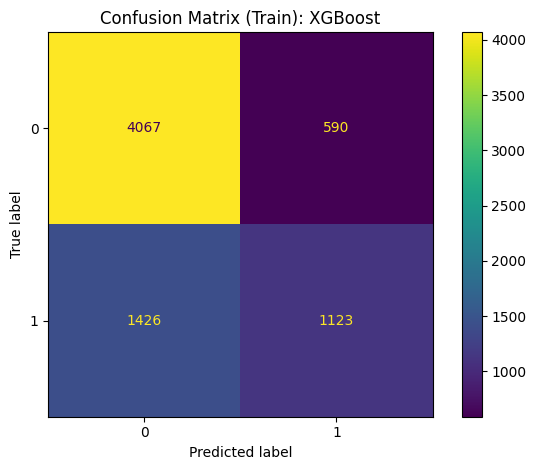

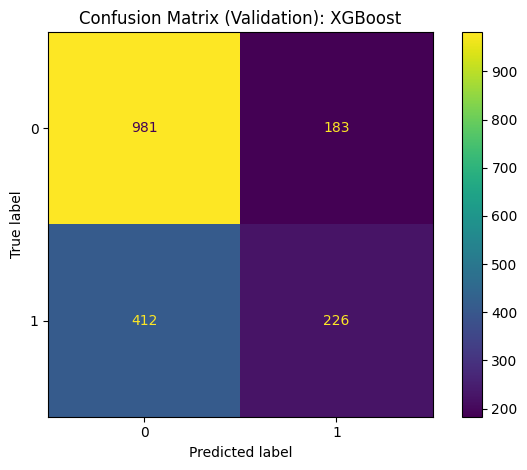

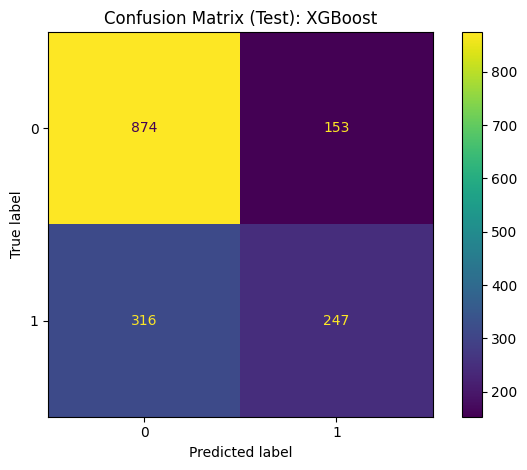

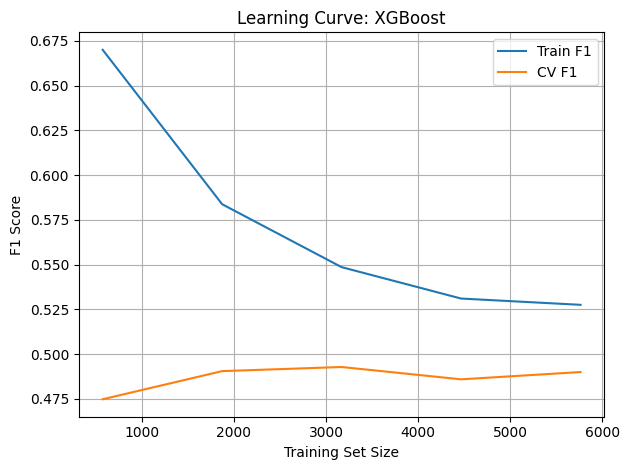

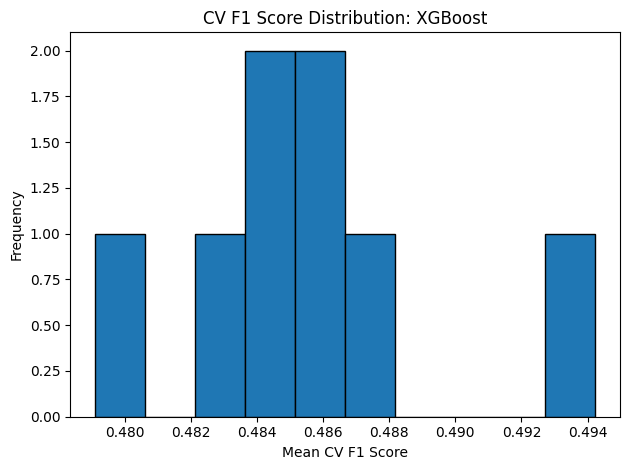

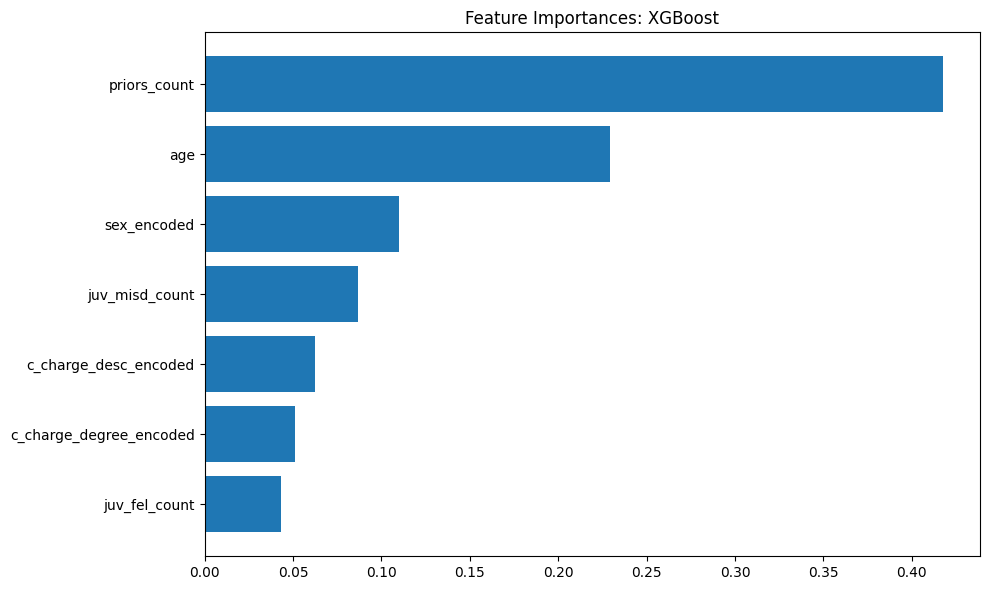

,Set,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Train,XGBoost,0.720,0.656,0.441,0.527,0.749
1,Validation,XGBoost,0.670,0.553,0.354,0.432,0.708
2,Test,XGBoost,0.705,0.618,0.439,0.513,0.724


In [ ]:
# # XGBOOST FINETUNING

# # Import required packages due to code state reset
# import pandas as pd
# import json
# import os
# import joblib
# import matplotlib.pyplot as plt
# from sklearn.model_selection import StratifiedKFold, GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from sklearn.metrics import (
#     make_scorer, f1_score, accuracy_score, precision_score, recall_score,
#     roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
# )

# # Load the dataset again
# df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
# X = df.drop("is_recid", axis=1)
# y = df["is_recid"]

# # Split into trainval (85%) and test (15%) set
# X_trainval, X_test, y_trainval, y_test = train_test_split(
#     X, y, test_size=0.15, stratify=y, random_state=42
# )

# # Cross-validation setup
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Parameter grids for tuning
# param_grids = {
#     "XGBoost": {
#         "clf__n_estimators": [50, 100],
#         "clf__max_depth": [3, 5],
#         "clf__learning_rate": [0.1, 0.3]
#     }
# }

# # Base model pipelines
# pipelines = {
#     "XGBoost": Pipeline([
#         ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
#     ])
# }

# # Use F1-score for tuning
# scorer = make_scorer(f1_score)

# os.makedirs("../reports", exist_ok=True)

# # Run GridSearchCV for both models
# best_estimators_xg = {}
# for name, pipeline in pipelines.items():
#     grid_search = GridSearchCV(
#         estimator=pipeline,
#         param_grid=param_grids[name],
#         scoring=scorer,
#         cv=cv,
#         n_jobs=-1,
#         verbose=0
#     )
#     grid_search.fit(X_trainval, y_trainval)
#     best_estimators_xg[name] = grid_search.best_estimator_

# # Evaluate the best estimators and extract metrics
# evaluation_results = []

# for name, model in best_estimators_xg.items():
#     y_proba = model.predict_proba(X_trainval)[:, 1]
#     y_pred = model.predict(X_trainval)

#     accuracy = accuracy_score(y_trainval, y_pred)
#     precision = precision_score(y_trainval, y_pred)
#     recall = recall_score(y_trainval, y_pred)
#     f1 = f1_score(y_trainval, y_pred)
#     auc = roc_auc_score(y_trainval, y_proba)
#     cm = confusion_matrix(y_trainval, y_pred)

#     # Display Confusion Matrix
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
#     disp.plot()
#     plt.title(f"Confusion Matrix: {name}")
#     plt.grid(False)
#     plt.tight_layout()
#     plt.savefig(f"../reports/confusion_matrix_finetuned_{name.lower().replace(' ', '_')}.png")
#     plt.show()

#     evaluation_results.append({
#         "Model": name,
#         "Best Parameters": model.get_params(),
#         "Accuracy": round(accuracy, 3),
#         "Precision": round(precision, 3),
#         "Recall": round(recall, 3),
#         "F1 Score": round(f1, 3),
#         "AUC": round(auc, 3),
#         "Confusion Matrix": cm
#     })


#     # Save only best tuned hyperparameters
#     with open(f"../reports/best_params_{name.lower().replace(' ', '_')}.json", "w") as f:
#         json.dump(grid_search.best_params_, f, indent=2)

# # Create models directory if it doesn't exist
# os.makedirs("../models", exist_ok=True)

# # Save the tuned Random Forest model
# joblib.dump(best_estimators["Random Forest"], "../models/random_forest_finetuned.pkl")

# # Save metrics
# eval_df = pd.DataFrame(evaluation_results)
# eval_df.to_csv("../reports/tuned_xgboost_model_metrics_summary.csv", index=False)

# eval_df

# === XGBOOST OVERFITTING DETECTION & BASE EVALUATION ===

import os
import json
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    make_scorer, f1_score, accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
)

# === Load Data ===
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
X = df.drop("is_recid", axis=1)
y = df["is_recid"]

# === Train/Val/Test Split ===
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42
)

# === Cross-validation setup ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#=== Pipeline & Param Grid Original ===
param_grids = {
    "XGBoost": {
        "clf__n_estimators": [50, 100],
        "clf__max_depth": [3, 5],
        "clf__learning_rate": [0.1, 0.3],
        # "clf__scale_pos_weight": [1, 2, 3], #this is the critical parameter to increase F1, but Precision will drop
        # "clf__gamma": [0, 1],
        # "clf__subsample": [0.8, 1.0],
        # "clf__colsample_bytree": [0.8, 1.0]
    }
}

pipelines = {
    "XGBoost": Pipeline([
        ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
    ])
}

scorer = make_scorer(f1_score)

os.makedirs("../reports", exist_ok=True)
os.makedirs("../models", exist_ok=True)

# === Run GridSearchCV ===
best_estimators_xg = {}
# thresholds = np.linspace(0.50, 0.70, 21)  # e.g., 0.50, 0.51, ..., 0.70 - might help to increase F1!

for name, pipeline in pipelines.items():
    print(f"Training and tuning: {name}")
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        scoring=scorer,
        cv=cv,
        n_jobs=-1,
        verbose=0,
        return_train_score=True
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_estimators_xg[name] = best_model

    # Save model and best params
    joblib.dump(best_model, f"../models/{name.lower().replace(' ', '_')}_finetuned.pkl")
    with open(f"../reports/best_params_{name.lower().replace(' ', '_')}.json", "w") as f:
        json.dump(grid_search.best_params_, f, indent=2)

    pd.DataFrame(grid_search.cv_results_).to_csv(
        f"../reports/gridsearch_results_{name.lower().replace(' ', '_')}.csv", index=False
    )

    # === Evaluation on Train / Val / Test ===
    def evaluate_set(X_data, y_data, set_name):
        y_pred = best_model.predict(X_data)
        y_proba = best_model.predict_proba(X_data)[:, 1]

        acc = accuracy_score(y_data, y_pred)
        prec = precision_score(y_data, y_pred)
        rec = recall_score(y_data, y_pred)
        f1 = f1_score(y_data, y_pred)
        auc = roc_auc_score(y_data, y_proba)
        cm = confusion_matrix(y_data, y_pred)

        # Save confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
        disp.plot()
        plt.title(f"Confusion Matrix ({set_name}): {name}")
        plt.grid(False)
        plt.tight_layout()
        plt.savefig(f"../reports/confusion_matrix_{set_name.lower()}_{name.lower().replace(' ', '_')}.png")
        plt.show()

        # Save classification report
        report = classification_report(y_data, y_pred, target_names=["No Recidivism", "Recidivism"])
        with open(f"../reports/classification_report_{set_name.lower()}_{name.lower().replace(' ', '_')}.txt", "w") as f:
            f.write(report)

        return {
            "Set": set_name,
            "Model": name,
            "Accuracy": round(acc, 3),
            "Precision": round(prec, 3),
            "Recall": round(rec, 3),
            "F1 Score": round(f1, 3),
            "AUC": round(auc, 3)
        }

    evaluation_results = []
    evaluation_results.append(evaluate_set(X_train, y_train, "Train"))
    evaluation_results.append(evaluate_set(X_val, y_val, "Validation"))
    evaluation_results.append(evaluate_set(X_test, y_test, "Test"))

    # Save metrics
    eval_df = pd.DataFrame(evaluation_results)
    eval_df.to_csv(f"../reports/tuned_{name.lower().replace(' ', '_')}_model_metrics_summary.csv", index=False)

    # === Learning Curve ===
    train_sizes, train_scores, val_scores = learning_curve(
        best_model, X_train, y_train, cv=cv,
        scoring="f1", n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5),
        shuffle=True, random_state=42
    )
    plt.figure()
    plt.plot(train_sizes, train_scores.mean(axis=1), label="Train F1")
    plt.plot(train_sizes, val_scores.mean(axis=1), label="CV F1")
    plt.xlabel("Training Set Size")
    plt.ylabel("F1 Score")
    plt.title(f"Learning Curve: {name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"../reports/learning_curve_{name.lower().replace(' ', '_')}.png")
    plt.show()

    # === CV Score Distribution ===
    cv_scores = grid_search.cv_results_["mean_test_score"]
    plt.figure()
    plt.hist(cv_scores, bins=10, edgecolor="k")
    plt.title(f"CV F1 Score Distribution: {name}")
    plt.xlabel("Mean CV F1 Score")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(f"../reports/cv_score_distribution_{name.lower().replace(' ', '_')}.png")
    plt.show()

    # === Feature Importances (from XGBoost) ===
    importances = best_model.named_steps["clf"].feature_importances_
    feature_names = X.columns
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"])
    plt.title(f"Feature Importances: {name}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(f"../reports/feature_importance_{name.lower().replace(' ', '_')}.png")
    plt.show()

    importance_df.to_csv(f"../reports/feature_importances_{name.lower().replace(' ', '_')}.csv", index=False)

# Final summary
eval_df


Validate and evaluate baseline model:

Best threshold selected: 0.63 (Precision=0.614, F1=0.403)


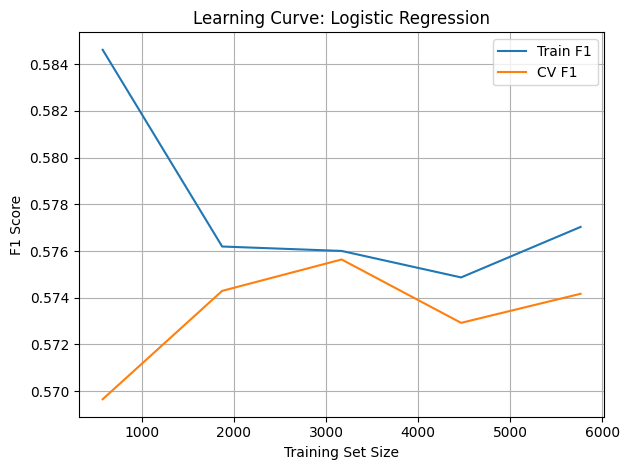

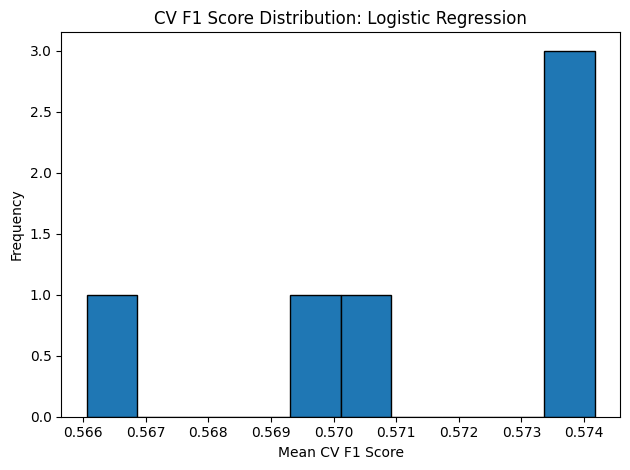

,Set,Model,Threshold,Accuracy,Precision,Recall,F1 Score,AUC
0,Train,Logistic Regression,0.63,0.696,0.642,0.319,0.426,0.712
1,Validation,Logistic Regression,0.63,0.685,0.614,0.299,0.403,0.704
2,Test,Logistic Regression,0.63,0.688,0.611,0.327,0.426,0.706


In [178]:
# # Import required packages due to code state reset
# import pandas as pd
# import json
# import os
# import joblib
# import matplotlib.pyplot as plt
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import (
#     make_scorer, f1_score, accuracy_score, precision_score, recall_score,
#     roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
# )
# from sklearn.model_selection import StratifiedKFold, GridSearchCV

# # Load the dataset again
# df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
# X = df.drop("is_recid", axis=1)
# y = df["is_recid"]

# # Split into trainval (85%) and test (15%) set
# X_trainval, X_test, y_trainval, y_test = train_test_split(
#     X, y, test_size=0.15, stratify=y, random_state=42
# )

# # Cross-validation setup
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Pipeline
# logreg_pipe = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", LogisticRegression(max_iter=1000, random_state=42))
# ])

# # Parameter grid
# logreg_param_grid = {
#     "clf__C": [0.01, 0.1, 1, 10],
#     "clf__penalty": ["l2"],
#     "clf__solver": ["lbfgs"]  # L2 is only compatible with lbfgs/saga
# }

# # Use F1-score for tuning
# scorer = make_scorer(f1_score)

# os.makedirs("../reports", exist_ok=True)

# # Run GridSearchCV
# name = "Logistic Regression"
# grid_search = GridSearchCV(
#     estimator=logreg_pipe,
#     param_grid=logreg_param_grid,
#     scoring=scorer,
#     cv=cv,
#     n_jobs=-1,
#     verbose=0
# )
# grid_search.fit(X_trainval, y_trainval)
# best_estimators_log = {name: grid_search.best_estimator_}

# # Evaluate the best estimators and extract metrics
# evaluation_results = []

# for name, model in best_estimators_log.items():
#     y_proba = model.predict_proba(X_trainval)[:, 1]
#     y_pred = model.predict(X_trainval)

#     accuracy = accuracy_score(y_trainval, y_pred)
#     precision = precision_score(y_trainval, y_pred)
#     recall = recall_score(y_trainval, y_pred)
#     f1 = f1_score(y_trainval, y_pred)
#     auc = roc_auc_score(y_trainval, y_proba)
#     cm = confusion_matrix(y_trainval, y_pred)

#     # Display Confusion Matrix
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
#     disp.plot()
#     plt.title(f"Confusion Matrix: {name}")
#     plt.grid(False)
#     plt.tight_layout()
#     plt.savefig(f"../reports/confusion_matrix_finetuned_{name.lower().replace(' ', '_')}.png")
#     plt.show()

#     evaluation_results.append({
#         "Model": name,
#         "Best Parameters": model.get_params(),
#         "Accuracy": round(accuracy, 3),
#         "Precision": round(precision, 3),
#         "Recall": round(recall, 3),
#         "F1 Score": round(f1, 3),
#         "AUC": round(auc, 3),
#         "Confusion Matrix": cm
#     })


#     # Save only best tuned hyperparameters
#     with open(f"../reports/best_params_{name.lower().replace(' ', '_')}.json", "w") as f:
#         json.dump(grid_search.best_params_, f, indent=2)

# # Create models directory if it doesn't exist
# os.makedirs("../models", exist_ok=True)

# # Save the tuned Random Forest model
# joblib.dump(best_estimators["Random Forest"], "../models/random_forest_finetuned.pkl")

# # Save metrics
# eval_df = pd.DataFrame(evaluation_results)
# eval_df.to_csv("../reports/tuned_logreg_model_metrics_summary.csv", index=False)

# eval_df

import os
import json
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    make_scorer, f1_score, accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve

# === Load Data ===
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")
X = df.drop("is_recid", axis=1)
y = df["is_recid"]

# === Split Data ===
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42)

# === Cross-validation setup ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === Pipeline and Param Grid ===
# logreg_pipe = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", LogisticRegression(max_iter=1000, random_state=42))
# ])

# logreg_param_grid = {
#     "clf__C": [0.01, 0.1, 1, 10],
#     "clf__penalty": ["l2"],
#     "clf__solver": ["lbfgs"]
# }

logreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced"))
])

logreg_param_grid = {
    "clf__C": [0.001, 0.005, 0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs"]
}

scorer = make_scorer(f1_score)
os.makedirs("../reports", exist_ok=True)
os.makedirs("../models", exist_ok=True)

# === Train with GridSearchCV ===
name = "Logistic Regression"
grid_search = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=logreg_param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=0,
    return_train_score=True
)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

joblib.dump(best_model, f"../models/{name.lower().replace(' ', '_')}_finetuned.pkl")
with open(f"../reports/best_params_{name.lower().replace(' ', '_')}.json", "w") as f:
    json.dump(grid_search.best_params_, f, indent=2)

pd.DataFrame(grid_search.cv_results_).to_csv(
    f"../reports/gridsearch_results_{name.lower().replace(' ', '_')}.csv", index=False
)

# # === Evaluate and Save Metrics ===
# def evaluate(X_data, y_data, set_name):
#     y_proba = best_model.predict_proba(X_data)[:, 1]
#     y_pred = best_model.predict(X_data)

#     acc = accuracy_score(y_data, y_pred)
#     prec = precision_score(y_data, y_pred)
#     rec = recall_score(y_data, y_pred)
#     f1 = f1_score(y_data, y_pred)
#     auc = roc_auc_score(y_data, y_proba)
#     cm = confusion_matrix(y_data, y_pred)

#     # Confusion Matrix
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
#     disp.plot()
#     plt.title(f"Confusion Matrix ({set_name}): {name}")
#     plt.grid(False)
#     plt.tight_layout()
#     plt.savefig(f"../reports/conf_matrix_{set_name.lower()}_{name.lower().replace(' ', '_')}.png")
#     plt.show()

#     # Classification Report
#     report = classification_report(y_data, y_pred, target_names=["No Recidivism", "Recidivism"])
#     with open(f"../reports/classification_report_{set_name.lower()}_{name.lower().replace(' ', '_')}.txt", "w") as f:
#         f.write(report)

#     return {
#         "Set": set_name,
#         "Model": name,
#         "Accuracy": round(acc, 3),
#         "Precision": round(prec, 3),
#         "Recall": round(rec, 3),
#         "F1 Score": round(f1, 3),
#         "AUC": round(auc, 3)
#     }

# evaluation_results = []
# evaluation_results.append(evaluate(X_train, y_train, "Train"))
# evaluation_results.append(evaluate(X_val, y_val, "Validation"))
# evaluation_results.append(evaluate(X_test, y_test, "Test"))

# eval_df = pd.DataFrame(evaluation_results)
# eval_df.to_csv(f"../reports/tuned_{name.lower().replace(' ', '_')}_metrics_summary.csv", index=False)

# === Threshold tuning ===
thresholds = np.linspace(0.50, 0.75, 26)
y_val_proba = best_model.predict_proba(X_val)[:, 1]

threshold_results = []
for t in thresholds:
    y_pred_thresh = (y_val_proba >= t).astype(int)
    prec = precision_score(y_val, y_pred_thresh)
    f1 = f1_score(y_val, y_pred_thresh)
    threshold_results.append({"Threshold": t, "Precision": prec, "F1": f1})

threshold_df = pd.DataFrame(threshold_results)
best_row = threshold_df.loc[threshold_df["Precision"].idxmax()]  # prioritize Precision
best_threshold = best_row["Threshold"]
print(f"Best threshold selected: {best_threshold:.2f} (Precision={best_row['Precision']:.3f}, F1={best_row['F1']:.3f})")

# === Evaluation Function ===
def evaluate_thresholded(X_data, y_data, set_name):
    y_proba = best_model.predict_proba(X_data)[:, 1]
    y_pred = (y_proba >= best_threshold).astype(int)

    acc = accuracy_score(y_data, y_pred)
    prec = precision_score(y_data, y_pred)
    rec = recall_score(y_data, y_pred)
    f1 = f1_score(y_data, y_pred)
    auc = roc_auc_score(y_data, y_proba)
    cm = confusion_matrix(y_data, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix ({set_name}, threshold={best_threshold:.2f})")
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f"../reports/conf_matrix_threshold_{set_name.lower()}_{name.lower().replace(' ', '_')}.png")
    plt.close()

    report = classification_report(y_data, y_pred, target_names=["No Recidivism", "Recidivism"])
    with open(f"../reports/classification_report_threshold_{set_name.lower()}_{name.lower().replace(' ', '_')}.txt", "w") as f:
        f.write(report)

    return {
        "Set": set_name,
        "Model": name,
        "Threshold": best_threshold,
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "Recall": round(rec, 3),
        "F1 Score": round(f1, 3),
        "AUC": round(auc, 3)
    }

# Evaluate on all sets
eval_results = []
eval_results.append(evaluate_thresholded(X_train, y_train, "Train"))
eval_results.append(evaluate_thresholded(X_val, y_val, "Validation"))
eval_results.append(evaluate_thresholded(X_test, y_test, "Test"))

# Save metrics
eval_df = pd.DataFrame(eval_results)
eval_df.to_csv(f"../reports/threshold_tuned_{name.lower().replace(' ', '_')}_balanced_metrics.csv", index=False)


# === Learning Curve ===
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, cv=cv,
    scoring="f1", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    shuffle=True, random_state=42
)
plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), label="Train F1")
plt.plot(train_sizes, val_scores.mean(axis=1), label="CV F1")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.title(f"Learning Curve: {name}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"../reports/learning_curve_{name.lower().replace(' ', '_')}.png")
plt.show()

# === CV Score Distribution ===
cv_scores = grid_search.cv_results_["mean_test_score"]
plt.figure()
plt.hist(cv_scores, bins=10, edgecolor="k")
plt.title(f"CV F1 Score Distribution: {name}")
plt.xlabel("Mean CV F1 Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(f"../reports/cv_score_distribution_{name.lower().replace(' ', '_')}.png")
plt.show()

# === Final Output ===
eval_df


Compare baseline models with classifiers - which one is best?

In [183]:
import pandas as pd

# === Load model metrics ===
logreg_df = pd.read_csv("../reports/threshold_tuned_logistic_regression_balanced_metrics.csv")
xgb_df = pd.read_csv("../reports/tuned_xgboost_model_metrics_summary.csv")
rf_df = pd.read_csv("../reports/threshold_tuned_randomforest_metrics.csv")

# === Add model names explicitly ===
logreg_df["Model"] = "Logistic Regression"
xgb_df["Model"] = "XGBoost"
rf_df["Model"] = "Random Forest"

# === Ensure all dataframes have the required columns ===
required_cols = ["Set", "Model", "Threshold", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"]
for df in [logreg_df, xgb_df, rf_df]:
    for col in required_cols:
        if col not in df.columns:
            df[col] = "-"  # placeholder if column not present

# Fill NaNs in Threshold column with "-" for consistency
for df in [logreg_df, xgb_df, rf_df]:
    df["Threshold"] = df["Threshold"].fillna("-")

# === Combine all model results ===
combined_df = pd.concat([logreg_df, xgb_df, rf_df], ignore_index=True)

# Sort set order explicitly
set_order = {"Test": 0, "Validation": 1, "Train": 2}
combined_df["SetOrder"] = combined_df["Set"].map(set_order)

# === Final sort: Test results at top, then by Precision → F1 → Recall → AUC → Accuracy
sorted_df = combined_df.sort_values(
    by=["SetOrder", "Precision", "F1 Score", "Recall", "AUC", "Accuracy"],
    ascending=[True, False, False, False, False, False]
).reset_index(drop=True)

# === Display nicely
print("\nModel Performance Comparison (Test > Val > Train | Sorted by Precision → F1):")
print(sorted_df[["Set", "Model", "Threshold", "Precision", "F1 Score", "Recall", "AUC", "Accuracy"]])

# === Best model on the TEST set ===
best_test_model = sorted_df[sorted_df["Set"] == "Test"].iloc[0]
print("\nBest Model on the TEST Set Based on Priority Metrics:")
print(best_test_model.to_frame().T)

# === Export the sorted table
sorted_df.to_csv("../reports/final_model_comparison.csv", index=False)



Model Performance Comparison (Test > Val > Train | Sorted by Precision → F1):
          Set                Model Threshold  Precision  F1 Score  Recall  \
0        Test        Random Forest       0.7      0.636     0.331   0.224   
1        Test              XGBoost         -      0.618     0.513   0.439   
2        Test  Logistic Regression      0.63      0.611     0.426   0.327   
3  Validation        Random Forest       0.7      0.622     0.279   0.180   
4  Validation  Logistic Regression      0.63      0.614     0.403   0.299   
5  Validation              XGBoost         -      0.553     0.432   0.354   
6       Train        Random Forest       0.7      0.726     0.350   0.231   
7       Train              XGBoost         -      0.656     0.527   0.441   
8       Train  Logistic Regression      0.63      0.642     0.426   0.319   

     AUC  Accuracy  
0  0.718     0.680  
1  0.724     0.705  
2  0.706     0.688  
3  0.702     0.671  
4  0.704     0.685  
5  0.708     0.670  
6  

Save the two selected models Random Forest and XGBoost in /models as .pkl file for further processing:

Further validation and evaluation of the two selected models Random Forest and XGBoost.

Debiasing method + fairness metrics
Reflection and interpretation